# Assingment 1 - MRI Contrast Classifier
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis


Welcome to the first course assignments! We have collected a dataset based on the popular BraTS challenge (http://braintumorsegmentation.org/), containing MRI slices of the brain, of different contrasts (sometimes referred to as modalities): T1-weighted (T1w), T1-weighted with contrast agent (T1w-CE), T2-weighted (T2w), and FLAIR, also a manually segmented binary map of a tumor, if visible on the slice. 

The assignments will build on each other, and all three of them will use the same dataset and the same data generator so take your time to familiarize yourself with these.

In the first assignments you are tasked with training a convolutional neural network to classify the acquired MR data into their contrasts (T1w, T1w-CE, T2w, FLAIR).

The code below is a working, but poor implementation of classifying between T1w and T2w contrasts. Your exercise is to expand and improve the code so the final model handles all four contrasts, and achieves an accuracy of $95\%$. 

The most important aspect of the assignment is that all your choices in the final code are explained and supported in writing. Show your though process, even if you have managed to improve the accuracy by trial and error. Make sure that in the report you include:
- How you reached the required performances
- Plot the confusion matrix of the validation data, using the final model.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the current setup, and how to solve them.

Upload the updated notebook to Canvas before February $16^{th}$, 15:00.

Good luck and have fun!

## Environment setup
conda create --name 3ra023vt23 python=3.8.12
- You now have an environment named “3ra023vt23”. Activate by:
$ conda activate 3ra023vt23
% Blank row

- Install CUDA and cuDNN:
conda install cudatoolkit=10.1.243 cudnn=7.6.5
- Install Tensorflow **with GPU** support:
conda install tensorflow-gpu=2.2.0
- Or, install Tensorflow **without GPU** support:
conda install tensorflow=2.2.0
- Install the other packages we need:
conda install jupyter=1.0.0
conda install matplotlib=3.5.0
conda install scikit-learn=1.0.2
conda install scikit-image=0.18.3

In [1]:
import os
import numpy as np
np.random.seed(2023)  # Set seed for reproducibility
import tensorflow as tf
tf.random.set_seed(2023)
!pip install tqdm # Adding tqdm to use progress bars.
from tqdm import tqdm

2023-02-15 23:30:19.133952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 23:30:19.631650: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-02-15 23:30:19.631697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-02-15 23:30:19.631702: W tensorflow/compiler/tf2t

In [2]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


2023-02-15 23:31:51.573832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 23:31:51.577551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 23:31:51.577810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!

In [4]:
gen_dir = "./data/"  # Change if you have copied the data locally on your machine
array_labels = ['t1', 't1ce', 't2', 'flair']  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
N_CLASSES = len(array_labels)
batch_size = 4

gen_train = DataGenerator(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? Their order will be the same as their unpacking order during training!
# NOTE: What batch size are you using? Should you use more? Or less?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

### Let's plot some example images from the dataset:

/tmp/ipykernel_6810/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


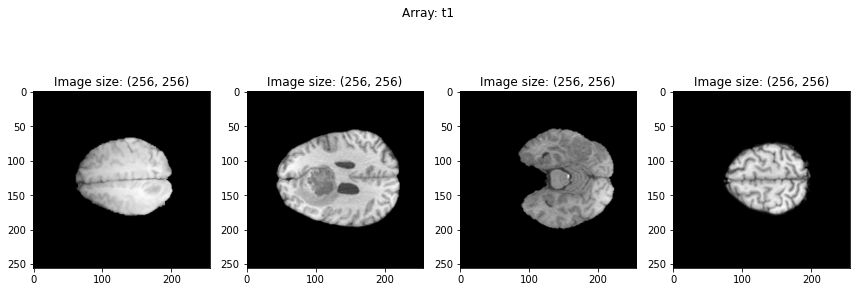

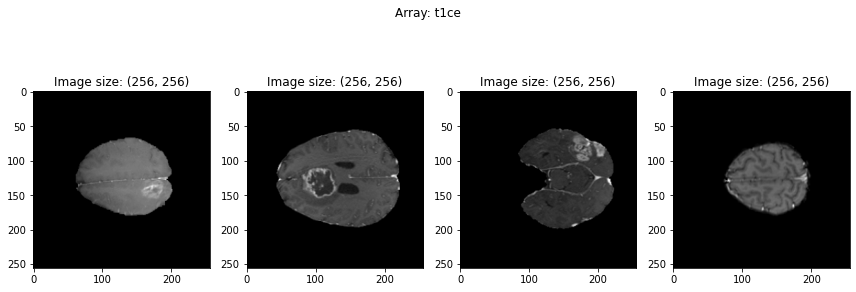

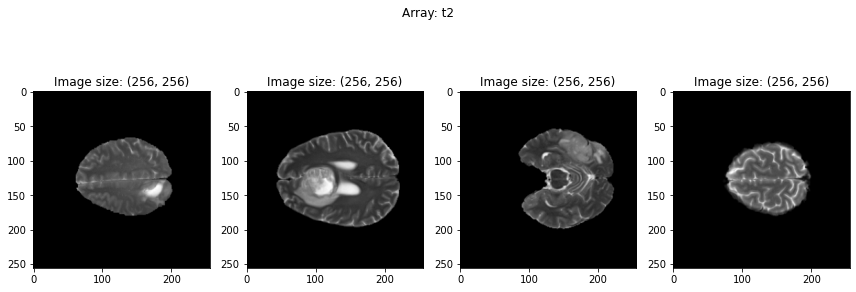

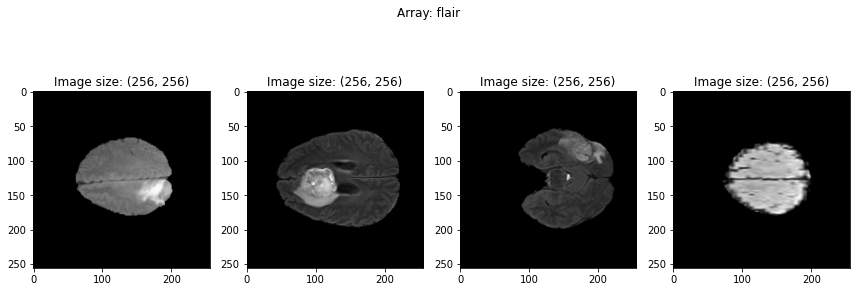

In [5]:
imgs = gen_train[3]
for inp in range(np.shape(imgs)[0]):
    plt.figure(figsize=(12,5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(imgs[inp][i, :, :, 0], cmap='gray')
        plt.title('Image size: ' + str(np.shape(imgs[inp][i, :, :, 0])))
        plt.tight_layout()
    plt.suptitle('Array: ' + gen_train.arrays[inp])
    plt.show()

### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

A quick summery of the data sizes:

In [6]:
# A quick summary of the data:
print(f"Number of training images: {str(len(gen_train.file_list))}")
print(f"Training batch size      : {str(gen_train.in_dims)}")

Number of training images: 8000
Training batch size      : [(4, 256, 256, 1), (4, 256, 256, 1), (4, 256, 256, 1), (4, 256, 256, 1)]


In [7]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

# NOTE: Take inspiration from the imported layers and components, however you are not required to use all of them.

In [8]:
# Define global variables:
H, W, IN_CHANS = gen_train.in_dims[0][1:]
POOLS = {"max":MaxPooling2D,"avg":AveragePooling2D}

In [9]:

from typing import List
def ConvBlock(out_channels:int,
             kernel_size:int=3,
             stride:tuple=(1,1),
             padding:str="same",
             activation:str=None,
             initializer:str="he_normal",
             bn:bool=False,
             dropout_rate:float=0,
             pooling=None,
            x:"Input"=None): # ConvBlock for backbone feature extraction.
    assert x is not None, "Did not provide input to the layer. Won't be able to build computational graph."
    x = Conv2D(out_channels,
                    kernel_size,
                    activation=activation,
                    padding=padding,
                    kernel_initializer=initializer,
                    use_bias=not bn,
                    )(x)
    if bn:
        x = BatchNormalization()(x)
    if dropout_rate>0:
        x = Dropout(dropout_rate)(x)
    if pooling:
        assert pooling in POOLS.keys(), "Not valid pooling method."
        x = POOLS[pooling](pool_size=(2, 2))(x)
    return x
    
def OutputBlock(x,
                n_classes:int,
                hidden_nodes:List[int]=None,
                hidden_activation:str="relu"):
    x = Flatten()(x)
    if hidden_nodes:
        for i in range(len(hidden_nodes)):
            x = Dense(hidden_nodes[i],activation=hidden_activation)(x)
    y = Dense(n_classes,activation="softmax")(x)
    return y
    
def ResBlock(out_channels:int,
             kernel_size:int=3,
             stride:tuple=(1,1),
             dropout_rate:float=0, # Dropout between main line segments.
             depth = 2, # Depth of main line.
            x:"Input"=None):
    act = Activation("relu")
    skip = Conv2D(out_channels,
                    1,
                    activation=None,
                    padding="same",
                    kernel_initializer="he_normal",
                    use_bias=False,
                    )(x)
    for i in range(depth): 
        x = Conv2D(out_channels,
                    kernel_size,
                    activation=None,
                    padding="same",
                    kernel_initializer="he_normal",
                    use_bias=False,
                    )(x)
        x = BatchNormalization()(x)
        x = act(x)
    y = act(skip+x)
    return y
    
    


In [10]:
def build_resnet(height, width, channels):
    inp = Input(shape=(height, width, channels), name='input_1')
    act = Activation("relu")
    drop = Dropout(0.3)
    initial_filters = 16
    x = Conv2D(filters=initial_filters,kernel_size=7,strides=(2,2),padding="same",use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = drop(x)
    # Layer 1.
    x = ResBlock(initial_filters*2,x=x,depth=2)
    x = MaxPooling2D(pool_size=(2,2))(x)
    # Layer 2
    x = ResBlock(initial_filters*4,x=x,depth=1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = drop(x)
    # Layer 3
    x = ResBlock(initial_filters*4,x=x,depth=1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = drop(x)
    # Layer 4
    x = ResBlock(initial_filters*8,x=x,depth=1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = drop(x)
    # Layer 5
    x = ResBlock(initial_filters*8,x=x,depth=1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = drop(x)
    # Layer 6
    x = ResBlock(initial_filters*16,x=x,depth=1)
    x = MaxPooling2D(pool_size=(2,2))(x)
    # FC layer
    flat = Flatten()(x)
    flat = Dense(64, activation='relu')(flat)
    y = Dense(4, activation='softmax')(flat)

    return Model(inputs=[inp], outputs=[y])


In [11]:
# NOTE: This is a very basic network, that you will need to improve.

def build_model(height, width, channels):
    inp = Input(shape=(height, width, channels), name='input_1')
    drop_rate = 0.1 # 0.1
    conv1 = Conv2D(8, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(inp)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(drop_rate)(pool1)

    conv2 = Conv2D(8, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(16, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(drop_rate)(pool3)
    
    conv4 = Conv2D(32, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(drop_rate/2)(pool4)
    
    conv5 = Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(pool4)
    conv5 = BatchNormalization()(conv5)
    
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    pool5 = Dropout(drop_rate/2)(pool5)

    conv6 = Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool5)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    #conv7 = Conv2D(128, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool6)
    #pool7 = MaxPooling2D(pool_size=(2, 2))(conv7)
    
    #conv8 = Conv2D(128, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool7)
    #pool8 = MaxPooling2D(pool_size=(2, 2))(conv8)
    
    flat = Flatten()(pool6)
    x = Dense(64, activation='relu')(flat)
    output_1 = Dense(4, activation='softmax')(x)

    return Model(inputs=[inp], outputs=[output_1])

# NOTE: A better designed network will improve performance. Look at the imported layers in the cell above for inspiration.

In [12]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

2023-02-15 23:32:15.472024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 23:32:15.472417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 23:32:15.472807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 23:32:15.473133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [13]:

# Create some tensors
# Test on GPU with computational graph
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [14]:
height, width, channels = gen_train.in_dims[0][1:]
with tf.device('/gpu:0'):
    model = build_model(height=height, width=width, channels=channels)
#model = build_resnet(height=height, width=width, channels=channels)

#model = build_improved_model()
model.summary()

# NOTE: Are the input sizes correct?
# NOTE: Are the output sizes correct?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are the model parameters split "evenly" between the layers? Or is there one huge layer?
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       72        
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       576   

In [15]:
# Load previous model for fine-tuning.
# model = keras.models.load_model("models/Ax")
# model.summary()

In [16]:
custom_lr = 0.001 # 0.00005, Original
weight_decay = 0.05
custom_optimizer = Adam(lr=custom_lr,decay=weight_decay) # Replaced RMSprop for Adam.
custom_loss = "categorical_crossentropy" # MSE i used for regression. We'd like to predict categorically.
custom_metric = "accuracy"

model.compile(loss=custom_loss,
              optimizer=custom_optimizer,
              metrics=[custom_metric])

# NOTE: Are you satisfied with the loss function?
# NOTE: Are you satisfied with the metric?
# NOTE: Are you satisfied with the optimizer? Look at the cell where the optimizers are imported for inspiration.
# NOTE: Are you satisfied with the optimizer's parameters?

In [17]:
def random_images(data_loader):
    t1, t1ce,t2,flair = data_loader[np.random.randint(0,len(data_loader))]
    return np.concatenate((t1, t1ce, t2, flair), axis=0)
ims = random_images(gen_train)
print(f"Input shape: {ims.shape}")
print(f"Max value: {ims.max()}")
print(f"Max value: {ims.min()}")
# NOTE: Ranges between 0->255 => Normalize to 0-1.

Input shape: (16, 256, 256, 1)
Max value: 255.0
Max value: 0.0


In [18]:
n_epochs = 50
n_classes = N_CLASSES
# Labels:
t1_label = tf.one_hot(np.repeat(0, batch_size), n_classes)
t1ce_label = tf.one_hot(np.repeat(1, batch_size), n_classes)
t2_label = tf.one_hot(np.repeat(2, batch_size), n_classes)
flair_label = tf.one_hot(np.repeat(3, batch_size), n_classes)
labels = np.concatenate((t1_label,t1ce_label,t2_label, flair_label), axis=0)
# Training Scheme
h = [1000,1000]
for epoch in range(n_epochs):
    training_loss = []
    validating_loss = []
    pbar = tqdm(enumerate(gen_train))
    # Training data
    for idx, (t1, t1ce,t2,flair) in pbar:
        if not idx%10:
            pbar.set_description(f"Training Epoch {epoch+1}/{n_epochs}. {idx+1}/{len(gen_train)} Batch. Training Loss: {h[0]:.3e}, Accuracy: {h[1]:.3e}")
        #labels = np.concatenate((t1_label,t1ce_label,t2_label, flair_label), axis=0)
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        h = model.train_on_batch(images, labels)
        training_loss.append(h)
        
    train_vals = np.array(training_loss) # Convert to numpy for faster computation.
    ave_train_loss = train_vals[:,0].mean() # Get average loss and accuracy over the epoch.
    ave_train_acc =  train_vals[:,1].mean()
    pbar.set_description(f"Training Epoch {epoch+1}/{n_epochs}. {idx+1}/{len(gen_train)} Batches. Training Loss: {ave_train_loss:.3e}, Accuracy: {ave_train_acc:.3e}")
    # Validation data
    for idx, (t1, t1ce,t2,flair) in enumerate(gen_val):
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        validating_loss.append(model.test_on_batch(images, labels)[-1])
        # pred = model.predict_on_batch(images)
    
    print(f"Epoch: {epoch + 1:2d}. Average accuracy - Training: {ave_train_acc:.3e}, Validation: {np.mean(validating_loss):.3e}")

Training Epoch 1/50. 1/2000 Batch. Training Loss: 1.000e+03, Accuracy: 1.000e+03: : 0it [00:00, ?it/s]2023-02-15 23:14:30.754653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-15 23:14:30.775009: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4099895000 Hz
2023-02-15 23:14:30.877500: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_recall_fscore_support
def confusion(model,gen_data, break_point:int=None):
    preds = []
    ls = []
    labels = np.concatenate((t1_label,t1ce_label,t2_label, flair_label), axis=0)
    # Test Validation
    for idx, (t1, t1ce,t2,flair) in enumerate(gen_data):
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        ls.append(labels.argmax(1))
        validating_loss.append(model.test_on_batch(images, labels)[-1])
        pred = model.predict_on_batch(images)
        preds.append(pred.argmax(1))
        if break_point and idx>break_point:
            break
    result = confusion_matrix(np.array(ls).flatten(), np.array(preds).flatten() , normalize='pred')
    cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = array_labels)
    return np.array(preds),np.array(ls),result,cm_display
def mean_average_accuracy(cm):
    return np.diag(cm).mean()


Training set - Accuracy: 0.9928438316532444
Validation set - Accuracy: 0.9334028472123554
Test set - Accuracy: 0.9241334057887737


[]

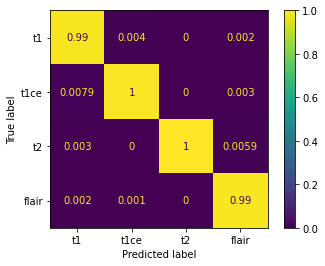

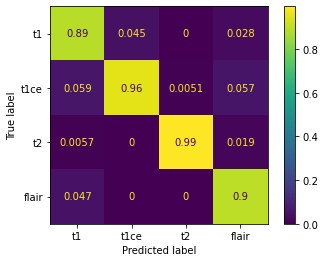

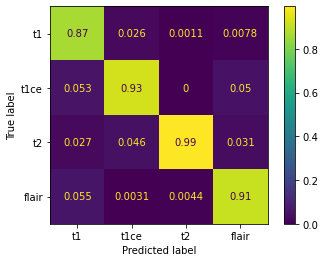

In [ ]:
train_preds,train_labels,cm_train,cm_disp_train = confusion(model,gen_train,len(gen_val))
print(f"Training set - Accuracy: {mean_average_accuracy(cm_train)}")
cm_disp_train.plot()
plt.plot()
val_preds,val_labels,cm_val,cm_disp_val = confusion(model,gen_val)
print(f"Validation set - Accuracy: {mean_average_accuracy(cm_val)}")
cm_disp_val.plot()
plt.plot()
test_preds,test_labels,cm_test,cm_disp_test = confusion(model,gen_test)
print(f"Test set - Accuracy: {mean_average_accuracy(cm_test)}")
cm_disp_test.plot()
plt.plot()

In [ ]:
model.save("models/Stefan")

INFO:tensorflow:Assets written to: models/Stefan/assets


In [ ]:
test_preds,test_labels,cm_test,cm_disp_test = confusion(gen_test)
cm_disp_val.plot()
plt.plot()

In [ ]:
new_model = keras.models.load_model("models/Umea")

In [ ]:
new_preds,new_labels,cm_new,cm_disp_new = confusion(new_model,gen_test)
mean_average_accuracy(cm_new)

0.9124263480204697

In [ ]:
def build_improved_model():
    dropout_rate = 0.2
    backbone = [
        [# Block 1
            8, # Out channels
            3, # Kernel size
            1, # Stride
            "same", # Padding
            "relu", # Activation
            "he_normal", # Convolutional kernel initializer
            False, # Batch Normalization
            0.0, # Dropout rate.
            "max", # Pooling layer.
        ],
        [# Block 2
            16, # Out channels
            3, # Kernel size
            1, # Stride
            "same", # Padding
            "relu", # Activation
            "he_normal", # Convolutional kernel initializer
            False, # Batch Normalization
            0.0, # Dropout rate.
            "max", # Pooling layer.
        ],
        [# Block 3
            32, # Out channels
            3, # Kernel size
            1, # Stride
            "same", # Padding
            "relu", # Activation
            "he_normal", # Convolutional kernel initializer
            True, # Batch Normalization
            dropout_rate, # Dropout rate.
            "max", # Pooling layer.
        ],
        [# Block 3
            64, # Out channels
            3, # Kernel size
            1, # Stride
            "same", # Padding
            "relu", # Activation
            "he_normal", # Convolutional kernel initializer
            False, # Batch Normalization
            dropout_rate/4, # Dropout rate.
            "max", # Pooling layer.
        ],
        [# Block 3
            64, # Out channels
            1, # Kernel size
            1, # Stride
            "valid", # Padding
            "relu", # Activation
            "he_normal", # Convolutional kernel initializer
            True, # Batch Normalization
            dropout_rate/8, # Dropout rate.
            "max", # Pooling layer.
        ],
        [# Block 3
            128, # Out channels
            1, # Kernel size
            1, # Stride
            "valid", # Padding
            "relu", # Activation
            "he_normal", # Convolutional kernel initializer
            True, # Batch Normalization
            dropout_rate/8, # Dropout rate.
            "max", # Pooling layer.
        ],
        [# Block 3
            128, # Out channels
            1, # Kernel size
            1, # Stride
            "valid", # Padding
            "relu", # Activation
            "he_normal", # Convolutional kernel initializer
            True, # Batch Normalization
            0, # Dropout rate.
            "max", # Pooling layer.
        ],
    ]
    print(f"Compiling CNN Model.")
    inp = Input(shape=(H, W, IN_CHANS), name='x')
    x = inp
    output_nodes = [64,32] # List of hidden nodes in output MLP, ReLU activations.
    for i,(chans,kernel,stride,padding,activation,init,bn,drop,pool) in enumerate(backbone):
        #print(f"Out-channels: {chans}\nKernel-size: {kernel}\nStride: {stride}\nPadding: {padding}\nActivation:{activation}\nBN: {bn}")
        x = ConvBlock(out_channels=chans,
             kernel_size=kernel,
             stride=stride,
             padding=padding,
             activation=activation,
             initializer=init,
             bn=bn,
             dropout_rate=drop,
             pooling=pool,
            x=x)
        print(f"Layer {i+1}/{len(backbone)}: Shape -> {x.shape}")
    y = OutputBlock(x,N_CLASSES,hidden_nodes=output_nodes)
    print(f"Final output -> Shape: {y.shape}")
    return Model(inputs=[inp], outputs=[y])
    